In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [252]:
# Defining system ’ s properties
N = 201; # number of grid points ( must be odd )
s = (N -1) / 2; # upper limit to FGH sum
m = 0.067; # electron ’ s effective mass
a0 = 100; # length scaling [ angstroms ]
Ry = 0.381 / m ; # energy scaling
L = 1000 / a0 ; # structure ’ s length
Lqw = 50 / a0 ; # QW width
x = np.linspace( -L , L , N ); # position vector

In [253]:
dx = x[2] - x[1]; # grid spacing
elf = 50; # electric field
elfx = 500 / a0 ; # electric field intervall
Ne = 1000; # number of points for absorption energy vector
hw = np.linspace(1e-5 ,4000 , Ne ); # absorption energy vector 
heaviside = lambda t: 0.5*(np.sign(t)+1) # Heaviside step function definition

MM = np.reshape([( i - j ) for i in range(N) for j in range(N) ],(N,N));

In [254]:
Tl = lambda l: (2 * np.pi * l / dx / N )**2
hh = lambda nv: (2 / N ) * np.cos( nv * 2*np.pi * MM / N ) * Tl ( nv );

HH = sum ([ hh( i ) for i in range(int(s+1)) ]); # Operator

In [255]:
# Concentration - dependent Ga ( cx ) In (1 - cx ) As / Al ( cy ) Ga (1 - cy ) As properties
cx = 0.47
cy = 0.6
dEgg = 1.247 * cy + 1.5 * (1 - cx ) - 0.41*(1 - cx )**2
if cy >= 0.45:
    dEg = 0.476 + 0.125* cy + 0.143* cy**2 + 1.5*(1 - cx ) - 0.4*(1 - cx )**2
    Eg_AlGaAs = (1.9 + 0.125* cy + 0.143 * cy**2) * 1e3
else:
    dEg = dEgg
    Eg_AlGaAs = (1.424 + 1.247 * cy ) * 1e3

BVOff_set = 0.44 * dEgg * 1e3 / Ry # BV band offset
BCOff_set = ( dEg * 1e3 - BVOff_set ) / Ry # BC band offset
Eg_GaInAs = (0.36 + 0.63* cx + 0.43 * cx**2) * 1e3 # Band Gap
Eg = Eg_GaInAs / Ry # Admensional band gap

In [256]:
# Defining the square well potential
VBV = np.zeros( N ) - ( Eg + BVOff_set );
VBV[ np.argwhere( np.abs(x) < Lqw) ]  = - Eg ; # BV

VBC = np.zeros( N ) + BCOff_set;
VBC [ np.argwhere( np.abs(x) < Lqw)]  = 0; # BC

In [257]:
# Defining electric field Stark Effect
elfvec = np.zeros( N );
ind = np.argwhere( np.abs( x ) < elfx ) # indexes
elfvec[ind] = ( x[ind] + x[ind[-1]]) * elf / 2;
elfvec[ind[-1][0]:] = x[ind[-1][0]] * elf ;
VBV = VBV + elfvec ; # Add to BV
VBC = VBC + elfvec ; # Add to BC

In [258]:
# Diagonalization
VBV_calc = -( VBV + Eg ); # Re - leveling BV for calculation purposes
HBV = ( HH + VBV_calc * np.eye (N , N )) * Ry ; # BV Hamiltonian
EBV_calc , eigBV = np.linalg.eig( HBV ); # BV Hamiltonian diagonalization
EBV = -( EBV_calc + Eg * Ry ); # Reverting leveling
HBC = ( HH + VBC * np.eye(N , N )) * Ry ; # BC Hamiltonian
EBC , eigBC = np.linalg.eig( HBC ); # BC Hamiltonian diagonalization

In [264]:
# Evaluating Absorption
Nv = 100
Ev = np.reshape([( EBC[ i ] - EBV[ j ]) for i in range(N) for j in range(Nv)],(N,Nv)); # Levels ’ s energy difference
# Oscillator Strength
f = np.abs([ np.dot( eigBV[:,j],eigBC[:,i]) for i in range(N) for j in range(Nv)])**2;
f = np.reshape(f,(N,Nv))

HS =[(heaviside(hw[e]-Ev[i,j])*f[i,j]/ hw[e]) for e in range(Ne) for i in range(N) for j in range(Nv)]
HS = np.reshape(HS,(Ne,N,Nv))

alpha = np.sum(np.sum( HS, axis= 2) , axis = 1); # Double sum over BV and BC states

In [265]:
# Black body radiation for Sunlight
h = 6.626e-34 # Constante de Planck [ h ] = Js
c = 3e8 # Velocidade da Luz [ c ] = m / s
kb = 1.38e-23 # Constante de Boltzmann [ kb ] = J / K
hc = 1.9864458e-25 # Jm
K = 1.38e-23 # J / K
T = 5775 # K
hwBlack = np.linspace(1e-5 ,4 ,30000)* 1.60218e-19 # J
w = hwBlack/ h
hwnm = w *1e-12*0.00414
I = 2 * np.pi * w**3 / (np.exp( hwBlack / ( K * T )) - 1) / ( c**2); # Irradiance

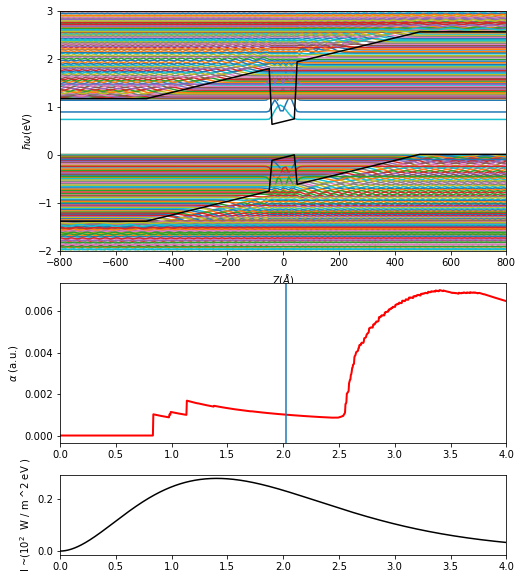

In [266]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 2, 1]},figsize=(8, 10))

[ax0.plot( x*a0,(-1500*eigBV[:,i]**2 + EBV[i])*1e-3) for i in range(200)];
[ax0.plot( x*a0,( 1500*eigBC[:,i]**2 + EBC[i])*1e-3) for i in range(200)];
ax0.plot( x*a0,( VBV*Ry )*1e-3, lw = 1.5 , color = 'black' );
ax0.plot( x*a0, VBC*Ry*1e-3, lw = 1.5 , color = 'black' );
ax0.set_xlim([-800 ,800])
ax0.set_ylim([-2 ,3])
ax0.set_xlabel(r'Z($\AA$)');
ax0.set_ylabel(r'$\hbar\omega$(eV)');

ax1.plot(hw*1e-3,  alpha, lw = 2 , color = 'red')
ax1.set_ylabel(r'$\alpha~$(a.u.)');
ax1.set_xlim([0 ,4])
ax1.axvline(Eg_AlGaAs*1e-3)

ax2.plot ( hwnm, I *1.60218e-19 / 100**4 , color = 'black' )
ax2.set_ylabel(r'I ~($10^{2}~$ W / m ^2 eV )');
ax2.set_xlim([0 ,4]);